In [561]:
import aeon
from aeon.datasets import load_from_tsf_file
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from random import choices
import numpy as np
import datetime
import pycatch22 as catch22
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [562]:
df, metadata = load_from_tsf_file("/Users/joshua/Documents/QuantumInspiredML/Sampling/electricity_hourly/electricity_hourly_dataset.tsf")

In [563]:
metadata

{'frequency': 'hourly',
 'forecast_horizon': None,
 'contain_missing_values': False,
 'contain_equal_length': True}

In [564]:
ts100 = df.iloc[100].series_value.to_numpy()

In [565]:
len(ts100)/24

1096.0

# How can we turn this into an interpolation problem?

Weekend versus weekday? Aggregate all households.

In [566]:
df

,series_name,start_timestamp,series_value
0,T1,2012-01-01 00:00:01,"[14.0, 18.0, 21.0, 20.0, 22.0, 20.0, 20.0, 20...."
1,T2,2012-01-01 00:00:01,"[69.0, 92.0, 96.0, 92.0, 91.0, 92.0, 91.0, 92...."
2,T3,2012-01-01 00:00:01,"[234.0, 312.0, 312.0, 312.0, 312.0, 187.0, 138..."
3,T4,2012-01-01 00:00:01,"[415.0, 556.0, 560.0, 443.0, 346.0, 340.0, 376..."
4,T5,2012-01-01 00:00:01,"[215.0, 292.0, 272.0, 213.0, 190.0, 178.0, 199..."
...,...,...,...
316,T317,2012-01-01 00:00:01,"[48.0, 65.0, 64.0, 65.0, 75.0, 64.0, 65.0, 69...."
317,T318,2012-01-01 00:00:01,"[38.0, 47.0, 43.0, 39.0, 40.0, 39.0, 49.0, 55...."
318,T319,2012-01-01 00:00:01,"[1558.0, 2177.0, 2193.0, 1315.0, 1378.0, 1250...."
319,T320,2012-01-01 00:00:01,"[182.0, 253.0, 218.0, 195.0, 191.0, 185.0, 191..."


In [569]:
df.iloc[100].start_timestamp.day_name()

'Sunday'

In [570]:
ts100 = df.iloc[100].series_value.to_numpy()

Try and window the data

In [571]:
len(ts100)/24.0

1096.0

In [572]:
windows = np.zeros(shape=(1096, 24))
labels = np.zeros(1096)
lower = 0
upper = 24
current_date = df.iloc[1].start_timestamp
for i in range(0, 1096):
    windows[i, :] = ts100[lower:upper]
    lower = upper
    upper += 24
    if (current_date.day_of_week == 5) or (current_date.day_of_week == 6):
        labels[i] = 1
    current_date += datetime.timedelta(hours=24) 

In [573]:
class_0_idxs = np.argwhere(labels == 0).flatten()
class_1_idxs = np.argwhere(labels == 1).flatten()
print(f"Num class 0: {len(class_0_idxs)} | Num class 1: {len(class_1_idxs)}") 

Num class 0: 783 | Num class 1: 313


Make an 80/20 train/test split

In [574]:
X_train, X_test, y_train, y_test = train_test_split(windows, labels, test_size=0.2, random_state=42)

In [575]:
ss_fit = StandardScaler().fit(X_train)
X_train_scaled = ss_fit.transform(X_train)
X_test_scaled = ss_fit.transform(X_test)

In [576]:
svc_fit = SVC().fit(X_train_scaled, y_train)
svc_fit.score(X_test_scaled, y_test)

0.9818181818181818

In [577]:
# save all data
np.savetxt("electricity100_X_train.txt", X_train)
np.savetxt("electricity100_X_test.txt", X_test)
np.savetxt("electricity100_y_train.txt", y_train)
np.savetxt("electricity100_y_test.txt", y_test)

# Aggregate all households

In [537]:
ts_all = [df.iloc[i].series_value.to_numpy() for i in range(321)]

In [538]:
windows_all = list()
labels_all = list()
for household in range(321):
    windows = np.zeros(shape=(1096, 24))
    labels = np.zeros(1096)
    lower = 0
    upper = 24
    current_date = df.iloc[1].start_timestamp
    for i in range(0, 1096):
        windows[i, :] = ts_all[household][lower:upper]
        lower = upper
        upper += 24
        if (current_date.day_of_week == 5) or (current_date.day_of_week == 6):
            labels[i] = 1
        current_date += datetime.timedelta(hours=24) 
    windows_all.append(windows)
    labels_all.append(labels)

Text(0.5, 1.0, 'Label : 0.0')

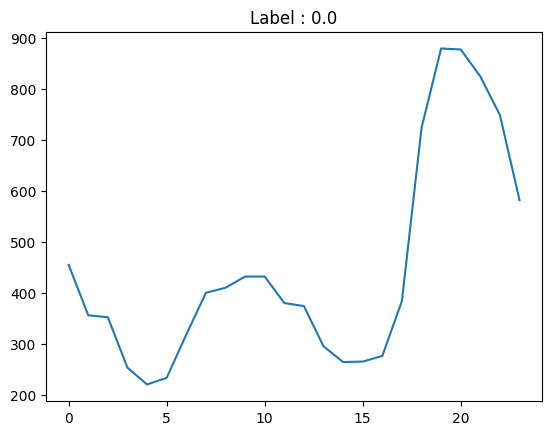

In [539]:
idx = 8
plt.plot(windows_all[3][idx])
plt.title(f"Label : {labels_all[3][idx]}")

All households have same timestamps and labels so we can use the same indices

In [540]:
class0_idxs = np.argwhere(labels_all[0] == 0).flatten()
class1_idxs = np.argwhere(labels_all[0] == 1).flatten()

In [541]:
class_0_all_windows_all_households = [windows_all[i][class0_idxs] for i in range(321)]
class_1_all_windows_all_households = [windows_all[i][class1_idxs] for i in range(321)]

In [542]:
class_0_all_windows_all_households = np.array(class_0_all_windows_all_households)
class_1_all_windows_all_households = np.array(class_1_all_windows_all_households)
class_1_all_windows_all_households.shape

(321, 313, 24)

In [543]:
class_0_final_ts = class_0_all_windows_all_households.reshape(321*783, 24)
class_1_final_ts = class_1_all_windows_all_households.reshape(321*313, 24)

In [544]:
class_1_final_ts.shape

(100473, 24)

In [545]:
all_class_0_ts = list()

In [546]:
len(ts_all)

321

In [547]:
len(class0_idxs) * len(ts_all)

251343

In [548]:
len(class1_idxs) * len(ts_all)

100473

Loop through and make class 0 and class 1 matrices

In [549]:
print(len(class_0_final_ts))
print(len(class_1_final_ts))

251343
100473


Now we can make it balanced by taking a random subset of N samples. Let's do 5000 samples per class.

In [550]:
class_0_final_ts[1]

array([ 18.,  18.,  17.,  16.,  15.,  15.,  14.,  14.,  67.,  68.,  66.,
        69.,  71.,  56.,  33.,  70., 102.,  23.,  67.,  47.,  29.,  74.,
        56.,  56.])

In [551]:
class_0_subset_idxs = np.random.choice(np.arange(len(class_0_final_ts)), size=5000, replace=False)
class_1_subset_idxs = np.random.choice(np.arange(len(class_1_final_ts)), size=5000, replace=False)

In [552]:
class_0_subset_ts = class_0_final_ts[class_0_subset_idxs, :]
class_1_subset_ts = class_1_final_ts[class_1_subset_idxs, :]

In [553]:
class_0_subset_labels = np.zeros(5000)
class_1_subset_labels = np.ones(5000)

In [554]:
subset_combined = np.vstack([class_0_subset_ts, class_1_subset_ts])
labels_combined = np.concatenate([class_0_subset_labels, class_1_subset_labels])

In [555]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(subset_combined, labels_combined, test_size=0.3, random_state=42)

In [556]:
ss_fit = StandardScaler().fit(X_train_sub)
X_train_scaled = ss_fit.transform(X_train_sub)
X_test_scaled = ss_fit.transform(X_test_sub)

In [558]:
svc_fit = SVC().fit(X_train_sub, y_train_sub)
svc_fit.score(X_test_sub, y_test_sub)

0.48833333333333334